### Importing necessary libraries and modules for the model.


#### Make sure you do not have errors or warnings after install packages.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

C:\Software\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Defining the path to the training directory and creating a list of class labels.
### Printing the class labels and the number of classes.

In [2]:
train_dir='training dataset/'
Labels = ['seam1', 'seam2','seam3','seam4']
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ")
    print (Labels[i])

class : 
0 seam1
1 seam2
2 seam3
3 seam4


In [3]:
print('Number of classes:',len(Labels))

Number of classes: 4


### Setting up the module selection parameters for feature extraction.
### Defining the handle base, image size, and feature vector size.
### Creating the module handle using the handle base.
### Setting the image size and batch size for training.

In [4]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 4

### Creating an instance of the ImageDataGenerator for data augmentation during training.


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


### Setting the trainable property of the feature extractor layer.


In [6]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
else:
  feature_extractor.trainable = True


print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([

    feature_extractor,

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2915908 (11.12 MB)
Trainable params: 2881796 (10.99 MB)
Non-trainable params: 34112 (13

### Compiling the model by specifying the optimiser, loss function, and metrics for evaluation.

In [8]:
LEARNING_RATE = 0.0001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

### Specifying the number of epochs and steps per epoch.


In [9]:
EPOCHS=21
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/21
400/400 [==============================] - 72s 166ms/step - loss: 0.6297 - accuracy: 0.7719 - val_loss: 0.3628 - val_accuracy: 0.9175
Epoch 2/21
400/400 [==============================] - 65s 162ms/step - loss: 0.3208 - accuracy: 0.9206 - val_loss: 0.2360 - val_accuracy: 0.9575
Epoch 3/21
400/400 [==============================] - 67s 168ms/step - loss: 0.2226 - accuracy: 0.9500 - val_loss: 0.1716 - val_accuracy: 0.9600
Epoch 4/21
400/400 [==============================] - 66s 166ms/step - loss: 0.1622 - accuracy: 0.9769 - val_loss: 0.1456 - val_accuracy: 0.9775
Epoch 5/21
400/400 [==============================] - 66s 166ms/step - loss: 0.1406 - accuracy: 0.9844 - val_loss: 0.1632 - val_accuracy: 0.9650
Epoch 6/21
400/400 [==============================] - 66s 166ms/step - loss: 0.1251 - accuracy: 0.9862 - val_loss: 0.1594 - val_accuracy: 0.9650
Epoch 7/21
400/400 [==============================] - 66s 166ms/step - loss: 0.1246 - accuracy: 0.9862 - val_loss: 0.1312 - val_ac

### Plotting the training and validation accuracy, as well as the training and validation loss over the epochs.

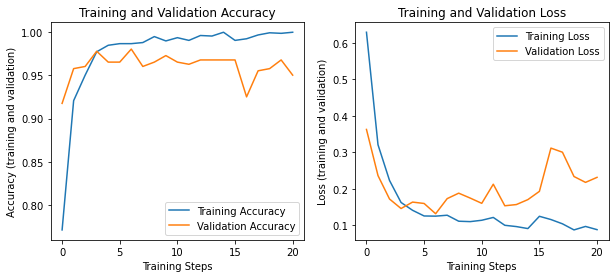

In [11]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Performing inference on the images and displaying the predicted class and confidence score.


#### install open cv (cv2) on your machine if you do not have it already

1/1 [==============================] - 0s 275ms/step
class: seam3, confidence: 1.000000


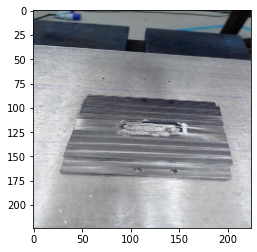

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 21ms/step
class: seam1, confidence: 0.998169


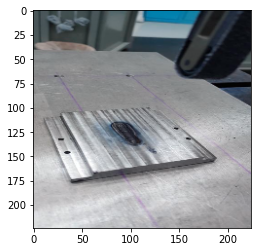

1/1 [==============================] - 0s 24ms/step
class: seam4, confidence: 0.925613


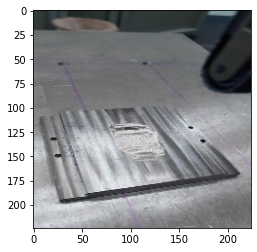

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: seam4, confidence: 0.934030


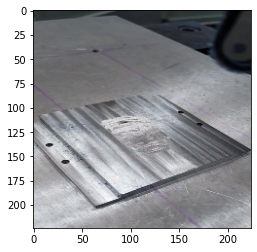

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 25ms/step
class: seam2, confidence: 0.999996


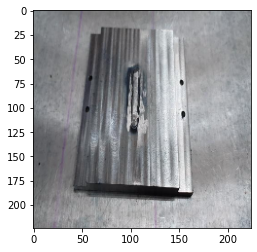

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 30ms/step
class: seam3, confidence: 0.999892


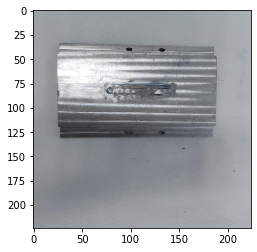

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: seam3, confidence: 0.999980


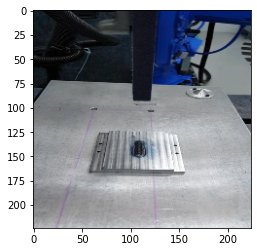

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: seam3, confidence: 0.999999


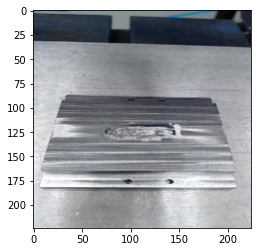

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 35ms/step
class: seam3, confidence: 0.999788


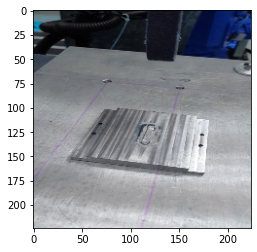

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 27ms/step
class: seam3, confidence: 1.000000


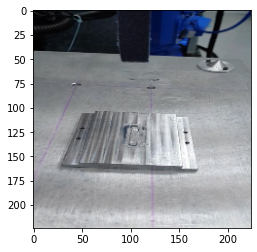

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 38ms/step
class: seam4, confidence: 0.995339


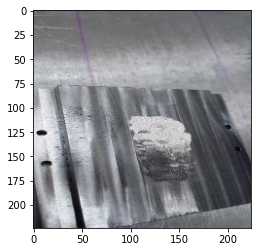

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: seam2, confidence: 0.999969


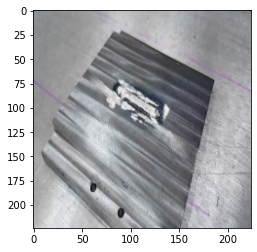

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 34ms/step
class: seam3, confidence: 1.000000


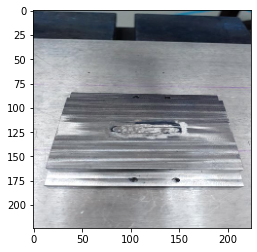

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 35ms/step
class: seam4, confidence: 0.372260


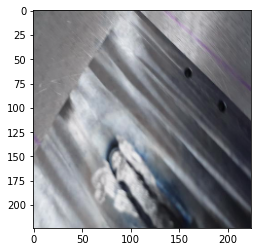

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 32ms/step
class: seam3, confidence: 0.999997


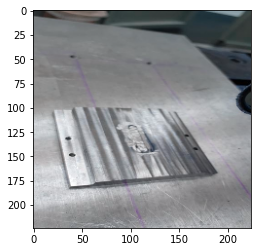

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 16ms/step
class: seam3, confidence: 0.960844


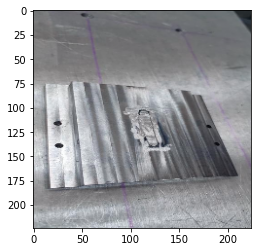

<Figure size 432x288 with 0 Axes>

In [13]:
import random
import cv2

def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

### Creating a DataFrame and heatmap visualization of the confusion matrix.


Confusion Matrix
100/100 [==============================] - 4s 39ms/step


<AxesSubplot:>

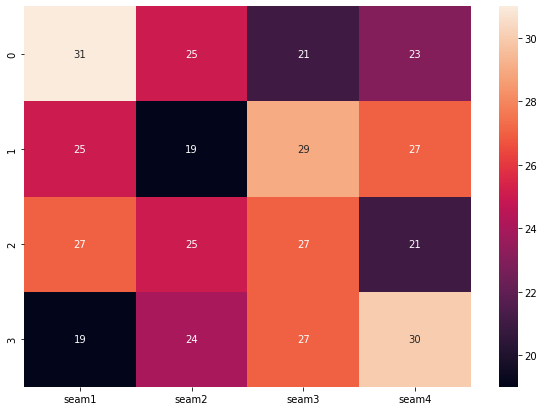

In [14]:
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sn
print('Confusion Matrix')
y = np.argmax(model.predict(validation_generator), axis=-1)
cm = metrics.confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))

sn.heatmap(df, annot=True, fmt='d')

### Saving the trained model to a directory with a timestamp as the export path.


#### Copy this timestamp for the last cell in this notebook

In [15]:
import time
t = time.time()
export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1695861854\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1695861854\assets


'/tmp/saved_models/1695861854'

### Now confirm that we can reload it, and it still gives the same results


In [17]:
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {Labels[class_idx]: probabilities[class_idx]}

### Randomly selecting images from the validation set and comparing the predictions between the original and reloaded models.


SOURCE: class: seam4, file: seam4\1540.jpg
1/1 [==============================] - 0s 249ms/step
PREDICTED: class: seam4, confidence: 0.956328


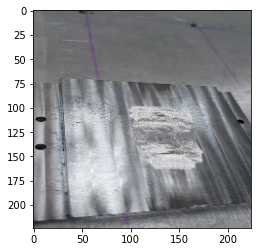

<Figure size 432x288 with 0 Axes>

SOURCE: class: seam1, file: seam1\186.jpg
1/1 [==============================] - 0s 36ms/step
PREDICTED: class: seam1, confidence: 1.000000


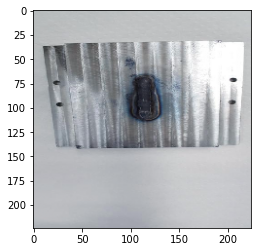

In [18]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

###  Importing necessary libraries, collects image paths and class labels from specified directories, creating a DataFrame to store the data, and prepares the data for further analysis and visualization using Seaborn and Matplotlib.


In [19]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

base_path = 'training dataset/'
class_folders = ['seam1', 'seam2', 'seam3', 'seam4']
class_labels = ['seam1', 'seam2', 'seam3', 'seam4']
data = []

for i, folder in enumerate(class_folders):
    folder_path = os.path.join(base_path, folder)
    file_paths = glob.glob(os.path.join(folder_path, '*.jpg')) 
    for file_path in file_paths:
        data.append((file_path, class_labels[i]))

df = pd.DataFrame(data, columns=['image_path', 'class_label'])


### Dataframe after the above step

In [20]:
df

,image_path,class_label
0,training dataset/seam1\1.jpg,seam1
1,training dataset/seam1\10.jpg,seam1
2,training dataset/seam1\100.jpg,seam1
3,training dataset/seam1\101.jpg,seam1
4,training dataset/seam1\102.jpg,seam1
...,...,...
1995,training dataset/seam4\1996.jpg,seam4
1996,training dataset/seam4\1997.jpg,seam4
1997,training dataset/seam4\1998.jpg,seam4
1998,training dataset/seam4\1999.jpg,seam4


### Creating a count plot using Seaborn to display the distribution of weld seam classes from the DataFrame on the x-axis and presents the plot with a title using Matplotlib.

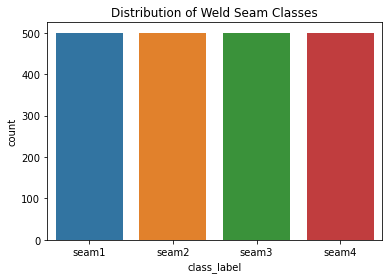

In [21]:
# Create countplot
sns.countplot(data=df, x='class_label')
plt.title('Distribution of Weld Seam Classes')
plt.show()

### Calculating seam width from images using OpenCV by performing edge detection, contour analysis, and rectangle calculation, and then applies this to the DataFrame, adding the results to a new column 'seam_width'.

In [24]:
import cv2
import numpy as np

def calculate_seam_width(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    edges = cv2.Canny(image, threshold1=100, threshold2=200)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    widest_contour = max(contours, key=lambda contour: cv2.contourArea(contour))
    
    x, y, w, h = cv2.boundingRect(widest_contour)
    
    seam_width = w
    
    return seam_width

df['seam_width'] = df['image_path'].apply(calculate_seam_width)


### Dataframe after the above step

In [25]:
df

,image_path,class_label,seam_width
0,training dataset/seam1\1.jpg,seam1,17
1,training dataset/seam1\10.jpg,seam1,188
2,training dataset/seam1\100.jpg,seam1,406
3,training dataset/seam1\101.jpg,seam1,145
4,training dataset/seam1\102.jpg,seam1,218
...,...,...,...
1995,training dataset/seam4\1996.jpg,seam4,154
1996,training dataset/seam4\1997.jpg,seam4,378
1997,training dataset/seam4\1998.jpg,seam4,286
1998,training dataset/seam4\1999.jpg,seam4,344


### Using Seaborn to create a box plot displaying the distribution of seam widths across weld seam classes, with labels and axes, and uses Matplotlib to show the plot.

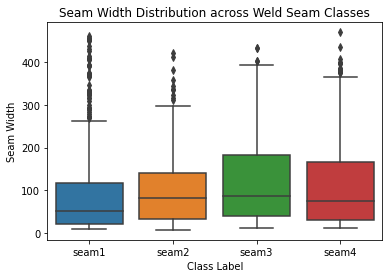

In [26]:
sns.boxplot(data=df, x='class_label', y='seam_width')
plt.title('Seam Width Distribution across Weld Seam Classes')
plt.xlabel('Class Label')
plt.ylabel('Seam Width')
plt.show()

### Using Seaborn to create a swarm plot illustrating the distribution of seam widths across weld seam classes, and Matplotlib to display the plot with labels and axes.

C:\Software\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Software\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 49.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Software\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 39.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Software\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 41.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


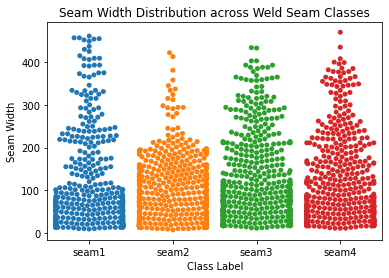

In [27]:
sns.swarmplot(data=df, x='class_label', y='seam_width')
plt.title('Seam Width Distribution across Weld Seam Classes')
plt.xlabel('Class Label')
plt.ylabel('Seam Width')
plt.show()

### Using Seaborn to create a histogram plot showcasing the distribution of seam widths with KDE, and uses Matplotlib to show the labeled plot.

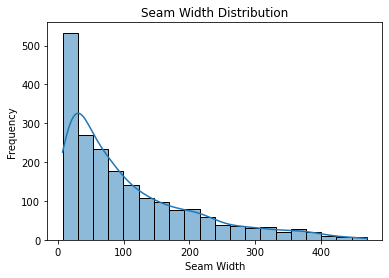

In [28]:
sns.histplot(data=df, x='seam_width', bins=20, kde=True)
plt.title('Seam Width Distribution')
plt.xlabel('Seam Width')
plt.ylabel('Frequency')
plt.show()

### Using Seaborn to create a scatter plot illustrating the distribution of seam widths across weld seam classes, and Matplotlib to display the labeled plot.

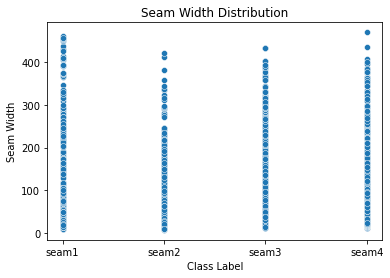

In [29]:
sns.scatterplot(data=df,x='class_label', y='seam_width')
plt.title('Seam Width Distribution')
plt.xlabel('Class Label')
plt.ylabel('Seam Width')
plt.show()

### Generating a visualization using Matplotlib's GridSpec, displaying color images from a label color dataset along with corresponding weld seam images. Each color image is shown with an inset displaying the associated weld seam image.


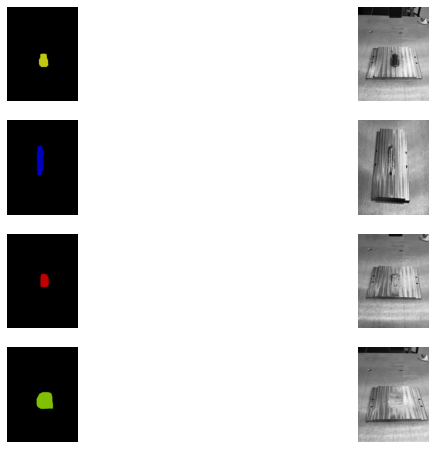

In [30]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2
import glob

weld_seam_path = 'training dataset/'

label_color_path = 'label color folder/'

class_labels = ['seam1', 'seam2', 'seam3', 'seam4']

fig = plt.figure(figsize=(12, 8))
gs = GridSpec(len(class_labels), 2, width_ratios=[3, 1], wspace=0.1, hspace=0.2)

for row, class_label in enumerate(class_labels):
    weld_image_path = os.path.join(weld_seam_path, class_label, '*.jpg')
    weld_image_path = glob.glob(weld_image_path)[0]  

    color_image_path = os.path.join(label_color_path, class_label, '*.png')
    color_image_path = glob.glob(color_image_path)[0]  

    color_image = cv2.imread(color_image_path)
    color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

    weld_image = cv2.imread(weld_image_path, cv2.IMREAD_GRAYSCALE)

    ax1 = fig.add_subplot(gs[row, 0])
    ax1.imshow(color_image)
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[row, 1])
    ax2.imshow(weld_image, cmap='gray')
    ax2.axis('off')

plt.show()

### Making prediction on a personally chosen image using a trained model, including preprocessing the image and interpreting the prediction.


#### Add the timestamp you have copied and replace the path to where your images are

In [38]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image

#Timestamp here
model = keras.models.load_model('/tmp/saved_models/1695861854')

#Add image path here
img_path = 'C:/ExampleUser/training dataset/seam3/1034.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 
img_array /= 255.0  


predictions = model.predict(img_array)

# Interpret the prediction
predicted_class = np.argmax(predictions[0]) 
class_labels = ['seam1', 'seam2', 'seam3', 'seam4'] 
predicted_label = class_labels[predicted_class]

print(f"Predicted class: {predicted_label}")


1/1 [==============================] - 0s 258ms/step
Predicted class: seam3
